In [1]:
import codecs
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import matplotlib.ticker as ticker
import numpy as np
import os
import progressbar
import random
import time
from time import sleep
import subprocess
import re
import seaborn as sns
sns.set(context='paper', style='whitegrid', font='Times New Roman', font_scale=1.8)

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data

In [2]:
torch.set_num_threads(1)

MAX_LENGTH = 50

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)


    def forward(self, input, hidden):
        word_embedded = self.embedding(input).view(1, 1, -1)
        word_embedded = self.dropout(word_embedded)
        output, hidden = self.gru(word_embedded, hidden)
        return output, hidden


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


class EncoderPOS(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderPOS, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p

        self.word_embedding = nn.Embedding(input_size, hidden_size)
        self.pos_embedding = nn.Embedding(MAX_LENGTH, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(hidden_size*2, hidden_size)

    def forward(self, input, hidden):
        index = input[0]
        word = input[1]
        word_embedded = self.word_embedding(word).view(1, 1, -1)
        pos_embedded = self.pos_embedding(torch.tensor([index], dtype=torch.long)).view(1, 1, -1)

        combined_embedding = torch.cat((word_embedded.squeeze(0), pos_embedded.squeeze(0)), 1)
        output = self.dropout(combined_embedding)
        output = self.linear(output)
        return output, hidden


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)



class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)


class NMT(nn.Module):
    def __init__(self, i2w_english, i2w_french, hidden_size, positional, criterion):
        super(NMT, self).__init__()
        if positional:
            self.encoder = EncoderPOS(len(i2w_french), hidden_size)
        else:
            self.encoder = EncoderRNN(len(i2w_french), hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, len(i2w_english))
        self.positional = positional
        self.criterion = criterion


    def forward(self, input_tensor, target_tensor):
        loss = 0

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_hidden = self.encoder.initHidden()
        encoder_outputs = torch.zeros(MAX_LENGTH, self.encoder.hidden_size)

        if input_length > MAX_LENGTH: input_length = MAX_LENGTH

        if self.positional:
            average_hidden = torch.zeros(1, self.encoder.hidden_size)

            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder((ei, input_tensor[ei]), encoder_hidden)
                average_hidden += encoder_output
                encoder_outputs[ei] = encoder_output[0, 0]
            encoder_hidden = (average_hidden/input_length).unsqueeze(0)
        else:
            for ei in range(input_length):
                encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token_en]])
        decoder_hidden = encoder_hidden

        # Use teacher forcing
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += self.criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

        loss.backward()

        return loss.item()/target_length


    def evaluate(self, w2i_french, i2w_english, sentence):
        with torch.no_grad():
            input_tensor = sentence_to_tensor(w2i_french, sentence)
            input_length = input_tensor.size()[0]
            encoder_hidden = self.encoder.initHidden()

            encoder_outputs = torch.zeros(MAX_LENGTH, self.encoder.hidden_size)

            if input_length > MAX_LENGTH: input_length = MAX_LENGTH

            if self.positional:
                average_hidden = torch.zeros(1, self.encoder.hidden_size)

                for ei in range(input_length):
                    encoder_output, encoder_hidden = self.encoder((ei, input_tensor[ei]), encoder_hidden)
                    average_hidden += encoder_output
                    encoder_outputs[ei] += encoder_output[0, 0]
                encoder_hidden = (average_hidden/input_length).unsqueeze(0)
            else:
                for ei in range(input_length):
                    encoder_output, encoder_hidden = self.encoder(input_tensor[ei], encoder_hidden)
                    encoder_outputs[ei] += encoder_output[0, 0]

            decoder_input = torch.tensor([[SOS_token_en]])  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token_en:
                    decoded_words.append("<eos>")
                    break
                else:
                    decoded_words.append(i2w_english[topi.item()])

                decoder_input = topi.squeeze().detach()
        return decoded_words, decoder_attentions[:di + 1]


def read_data(file_name):
    """
    Reads the data and returns it in a list.
    """

    f = codecs.open(file_name, "r", encoding='utf-8')
    return [line.strip().split() for line in f.readlines()]


def word_to_index(file_name):
    """
    Obtains the vocabulary of a file and returns it
    in a dictionary to be able to use w2i.
    """

    file = codecs.open(file_name, "r", encoding='utf-8')
    w2i = json.load(file)
    w2i["<sos>"] = len(w2i)
    return w2i


def index_to_word(dictionary):
    """
    Reverses the dictionary such that i2w can be used.
    """

    reversed_dict = {}

    for word, index in dictionary.items():
        reversed_dict[index] = word
    return reversed_dict


def sentence_to_indices(w2i, sentence):
    """
    Returns the indices of the words in a sentence in a list.
    """

    return [w2i[word] for word in sentence]


def sentence_to_tensor(w2i, sentence):
    """
    Returns the tensor of a sentence.
    """

    indices = sentence_to_indices(w2i, sentence)
    indices.append(w2i["<eos>"])
    return torch.tensor(indices, dtype=torch.long).view(-1, 1)


def train(input_sentence, target_sentence, w2i_english,
          w2i_french, nmt, nmt_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Does one iteration of training.
    """

    loss = 0
    output_sentence = []
    input_tensor = sentence_to_tensor(w2i_french, input_sentence)
    target_tensor = sentence_to_tensor(w2i_english, target_sentence)
    target_length = target_tensor.size(0)

    nmt_optimizer.zero_grad()
    loss = nmt.forward(input_tensor, target_tensor)

    nmt_optimizer.step()

    return loss


def train_dataset(w2i_english, w2i_french, train_english,
                  train_french, nmt, learning_rate):
    """
    Trains the Encoder-Decoder model for the entire data set.
    """

    start = time.time()

    nmt_optimizer = optim.SGD(nmt.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    total_loss = 0

    with progressbar.ProgressBar(max_value=100) as bar:
        # for iter in range(1, len(train_english) + 1)
        for iter in range(1, 100 + 1):
            input_sentence = train_french[iter-1]
            target_sentence = train_english[iter-1]
            loss = train(input_sentence, target_sentence, w2i_english,
                         w2i_french, nmt, nmt_optimizer, criterion)
            total_loss += loss
            bar.update(iter-1)
    return total_loss


def evaluate_dataset(w2i_french, i2w_english, nmt, val_french, val_english):
    """
    Evaluates the data set and returns the obtained predictions and loss.
    """

    predictions = []

    for i, input_sentence in enumerate(val_french):
        target_sentence = val_english[i]

        predicted_words, attentions = nmt.evaluate(w2i_french, i2w_english, val_french[i])
        
        predicted_sentence = ' '.join(predicted_words)
        predictions.append(predicted_sentence)
    return predictions


def save_model(model, positional, epoch, lr, train_loss, val_score):
    """
    Saves the NMT model to a file.
    """

    model_type = "rnn"
    if positional: model_type = "pos"

    path = "test_runs/models/" + model_type + "_lr" + str(lr) + "_epoch" + str(epoch) + \
        "_trainloss" + str(train_loss) + "_valscore" + str(val_score)
    torch.save(model.state_dict(), path)


def save_predictions(predictions, epoch, lr, train_loss, positional):
    """
    Saves the encoded predicted sentences decoded to a file.
    """

    model_type = "rnn"
    if positional: model_type = "pos"

    path = "test_runs/results/predictions_" + model_type + "_lr" + str(lr) + \
        "_epoch" + str(epoch) + "_trainloss" + str(train_loss) + ".txt"

    with codecs.open("temp_encoded.txt", "w", encoding='utf-8') as f:
        for sentence in predictions:
            f.write(sentence.split("<")[0] + "\n")
    f.close()

    command = "sed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > " + path
    # change to gsed if on macOS:
    # command = "gsed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > " + path
    
    os.system(command)
    os.remove("temp_encoded.txt")
    return path


def evaluate_predictions(predictions_path, val_path):
    """
    Computes BLEU score for predictions file.
    """
    command = " ".join(["perl", "multi-bleu.perl", val_path, "<", predictions_path])

    try:
        BLEU_full = "".join(re.split(r'BLEU = |\\n\'', str(subprocess.check_output(command, shell=True)))[1:])
        BLEU_score = re.split(r',', BLEU_full)[0].strip()
    except:
        BLEU_full = "error"
        BLEU_score = None

    return BLEU_score, BLEU_full


def save_losses(train_loss, val_score, learning_rate):
    """
    Appends the obtained losses to a file.
    """

    model_type = "rnn"
    if positional: model_type = "pos"
    path = model_type + "_lr" + str(learning_rate)

    with codecs.open("test_runs/results/trainlosses_" + path + ".txt", "a", encoding='utf-8') as train_file:
        train_file.write(str(train_loss) + "\n")
    train_file.close()

    with codecs.open("test_runs/results/valscores_" + path + ".txt", "a", encoding='utf-8') as val_file:
        val_file.write(str(val_score) + "\n")
    val_file.close()


def train_and_evaluate(w2i_english, w2i_french, train_english, train_french,
                       nmt, positional, num_epochs, learning_rate=0.01):
    """
    Trains the Encoder-Decoder for a certain amount of epochs.
    """

    train_losses = []
    val_scores = []

    for iter in range(1, num_epochs + 1):
        print("Iteration", iter, "of", num_epochs)
        train_loss = train_dataset(w2i_english, w2i_french,
                                   train_english, train_french,
                                   nmt, learning_rate)
        predictions = evaluate_dataset(w2i_french, i2w_english,
                                       nmt, val_french, val_english)

        predictions_path = save_predictions(predictions, iter, learning_rate, train_loss,
                                            positional)

        sleep(0.01)

        val_score, bleu_output = evaluate_predictions(predictions_path, "val/val.en")

        print("training loss:", train_loss)
        print("validation bleu:", bleu_output)
        train_losses.append(train_loss)
        val_scores.append(val_score)

        save_model(nmt, positional, iter, learning_rate, train_loss, val_score)
        save_losses(train_loss, val_score, learning_rate)

In [3]:
train_english = read_data("data/train_preprocessed.en")
train_french = read_data("data/train_preprocessed.fr")

val_english = read_data("data/val_preprocessed.en")
val_french = read_data("data/val_preprocessed.fr")

test_english = read_data("data/test_preprocessed.en")
test_french = read_data("data/test_preprocessed.fr")

w2i_french = word_to_index("data/train_preprocessed.fr.json")
w2i_english = word_to_index("data/train_preprocessed.en.json")

i2w_french = index_to_word(w2i_french)
i2w_english = index_to_word(w2i_english)

EOS_token_en = w2i_english["<eos>"]
SOS_token_en = w2i_english["<sos>"]

EOS_token_fr = w2i_french["<eos>"]
SOS_token_fr = w2i_french["<sos>"]

In [4]:
positional = False
num_epochs = 1
learning_rate = 0.001

# remove previous test run results
for file in os.listdir("test_runs/models/"):
    try:
        os.remove("test_runs/models/" + file)
    except:
        continue
for file in os.listdir("test_runs/results/"):
    try:
        os.remove("test_runs/results/" + file)
    except:
        continue
        
criterion = nn.NLLLoss()
nmt = NMT(i2w_english, i2w_french, 256, positional, criterion)
train_and_evaluate(w2i_english, w2i_french, train_english,
                   train_french, nmt, positional, num_epochs,
                   learning_rate)

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Iteration 1 of 1


100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


training loss: 652.0960498612656
validation bleu: 0.00, 2.2/0.0/0.0/0.0 (BP=1.000, ratio=4.167, hyp_len=50700, ref_len=12167)


# Plots for Training loss & Validation score

In [5]:
results_dir = 'results/'

In [6]:
def plot_loss(filepath, title, plt, color, label):
    losses = [(i+1, float(line)) for i, line in enumerate(open(filepath, 'r').readlines())]
    plt.plot([x[0] for x in losses], [x[1] for x in losses], '-', color=color, linewidth=0.8, label=label)
    for epoch, loss in losses:
        plt.plot(epoch, loss, 'o', color=color, markersize=8)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.ticklabel_format(style='sci', scilimits=(2,2), axis='y')
    plt.ylabel('loss')
    plt.ylim(30000, 200000)
    plt.xlabel('epochs')
    plt.title(title)
    return plt

def plot_bleu(filepath, title, plt, color, label):
    bleus = [(i+1, float(line)) for i, line in enumerate(open(filepath, 'r').readlines())]
    plt.plot([x[0] for x in bleus], [x[1] for x in bleus], '-', color=color, linewidth=0.8, label=label)
    for epoch, bleu in bleus:
        plt.plot(epoch, bleu, 'o', color=color, markersize=8)
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.ylabel('BLEU score')
    plt.xlabel('epochs')
    plt.ylim(-1,20)
    plt.title(title)
    return plt

In [7]:
rnn_train_loss_files = [results_dir + '/' + filename 
                    for filename in os.listdir(results_dir) 
                    if filename.startswith("trainlosses_rnn")]

pos_train_loss_files = [results_dir + '/' + filename 
                    for filename in os.listdir(results_dir) 
                    if filename.startswith("trainlosses_pos")]

rnn_val_score_files = [results_dir + '/' + filename 
                    for filename in os.listdir(results_dir) 
                    if filename.startswith("valscores_rnn")]

pos_val_score_files = [results_dir + '/' + filename 
                    for filename in os.listdir(results_dir) 
                    if filename.startswith("valscores_pos")]

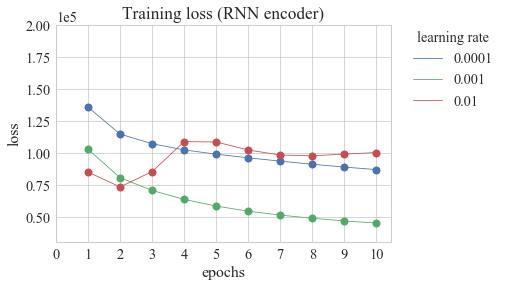

In [8]:
plt.figure()
learning_rates = []

for loss_file in rnn_train_loss_files:
    lr = "{0:.4f}".format(float(re.split(r'lr|.txt', loss_file)[1]))
    one_i = lr.find('1')
    lr = lr[:one_i+1]
    learning_rates.append(lr)

for i, lr in enumerate(sorted(learning_rates)):
    loss_file = [loss_file for loss_file in rnn_train_loss_files if str(float(lr)) in loss_file][0]
    plt = plot_loss(loss_file, 'Training loss (RNN encoder)', plt, 'C' + str(i), lr)
    
legend = plt.legend(title='learning rate', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(legend.get_title(),fontsize='x-large')
plt.savefig('figures/train_loss_rnn.eps', bbox_inches='tight')

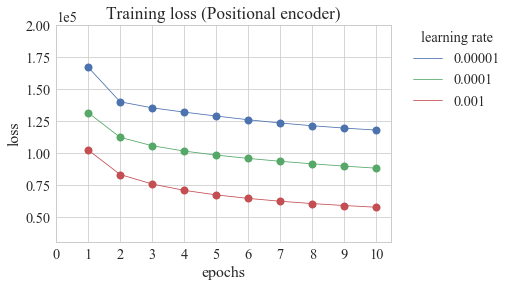

In [9]:
plt.figure()
learning_rates = []

for loss_file in pos_train_loss_files:
    lr = "{0:.5f}".format(float(re.split(r'lr|.txt', loss_file)[1]))
    one_i = lr.find('1')
    lr = lr[:one_i+1]
    learning_rates.append(lr)
    
for i, lr in enumerate(sorted(learning_rates)):
    loss_file = [loss_file for loss_file in pos_train_loss_files if str(float(lr)) in loss_file][0]
    plt = plot_loss(loss_file, 'Training loss (Positional encoder)', plt, 'C' + str(i), lr)
    
legend = plt.legend(title='learning rate', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(legend.get_title(),fontsize='x-large')
plt.savefig('figures/train_loss_pos.eps', bbox_inches='tight')

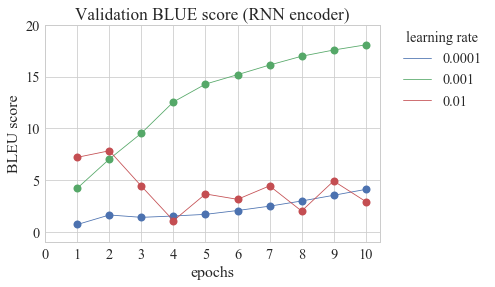

In [10]:
plt.figure()
learning_rates = []

for bleu_file in rnn_val_score_files:
    lr = "{0:.5f}".format(float(re.split(r'lr|.txt', bleu_file)[1]))
    one_i = lr.find('1')
    lr = lr[:one_i+1]
    learning_rates.append(lr)

for i, lr in enumerate(sorted(learning_rates)):
    score_file = [score_file for score_file in rnn_val_score_files if str(float(lr)) in score_file][0]
    plt = plot_bleu(score_file, 'Validation BLUE score (RNN encoder)', plt, 'C' + str(i), lr)
    
legend = plt.legend(title='learning rate', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(legend.get_title(),fontsize='x-large')
plt.savefig('figures/val_score_rnn.eps', bbox_inches='tight')

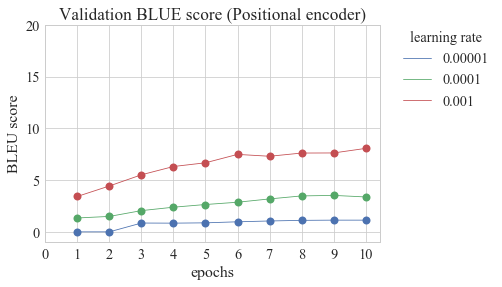

In [11]:
plt.figure()
learning_rates = []

for bleu_file in pos_val_score_files:
    lr = "{0:.5f}".format(float(re.split(r'lr|.txt', bleu_file)[1]))
    one_i = lr.find('1')
    lr = lr[:one_i+1]
    learning_rates.append(lr)

for i, lr in enumerate(sorted(learning_rates)):
    score_file = [score_file for score_file in pos_val_score_files if str(float(lr)) in score_file][0]
    plt = plot_bleu(score_file, 'Validation BLUE score (Positional encoder)', plt, 'C' + str(i), lr)
    
legend = plt.legend(title='learning rate', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(legend.get_title(),fontsize='x-large')
plt.savefig('figures/val_score_pos.eps', bbox_inches='tight')

# Attention visualization

input = un groupe de personnes s@@ al@@ u@@ ant quelqu&apos; un sur un b@@ al@@ c@@ on .
output = a group of people s@@ u@@ r@@ ro@@ un@@ ding a f@@ o@@ o@@ t on a w@@ al@@ k@@ way . <eos>


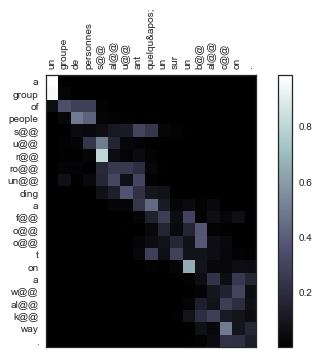

In [12]:
sns.set(style='white')

test_nmt = NMT(i2w_english, i2w_french, 256, positional, criterion)
test_nmt.load_state_dict(torch.load("models/rnn_lr0.001_epoch10_trainloss44968.94806789154_valscore18.06"))

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions[1:, 3:len(input_sentence.split(' ')) + 3].numpy(), cmap='bone')
    fig.colorbar(cax)
    
    xs = range(len(input_sentence.split(' ')))
    ax.set_xticks(xs)
    
    ys = range(len(output_words[:-2]))
    ax.set_yticks(ys)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = test_nmt.evaluate(w2i_french, i2w_english, input_sentence.split())
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)  

evaluateAndShowAttention(" ".join(val_french[788]))

# Test set evaluation

In [13]:
def ter_score(predictions_path, test_path, output_path): 
    predictions_corrected_path = predictions_path[:-4] + '_corrected.txt'
    f = open(predictions_path, "r", encoding="utf8")
    predictions_model = [line.strip() + ' (' + str(i) + ') \n' for i, line in enumerate(f.readlines())]
    f.close()

    val_corrected_path = test_path[:-4] + '_corrected.txt'
    f = open(test_path, 'r', encoding="utf8")
    val_model = [line.strip().lower() + ' (' + str(i) + ') \n' for i, line in enumerate(f.readlines())]
    f.close()
    
    file = open(val_corrected_path, "w")
    file.writelines(val_model)
    file.close()

    file = open(predictions_corrected_path, "w")
    file.writelines(predictions_model)
    file.close()
    
    output = ! java -jar evaluation_metrics/tercom-0.7.25/tercom.7.25.jar -r $val_corrected_path -h $predictions_corrected_path -n $output_path
    
    ter = output[-4].split(':')[1].split(' ')[1]
    return float(ter)

def meteor_score(predictions_path, test_path):
    output = ! java -Xmx2G -jar evaluation_metrics/meteor-1.5/meteor-1.5.jar $predictions_path $test_path
    meteor_score = output[-1].split(':')[1]
    return float(meteor_score)

def save_test_predictions(predictions, model):
    
    path = "results/test_predictions_" + model + ".txt"
    
    with codecs.open("temp_encoded.txt", "w", encoding='utf-8') as f:
        for sentence in predictions:
            f.write(sentence.split("<")[0] + "\n")
        f.close()

    command = "sed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > results/test_predictions_rnn.txt"
    # change to gsed if on macOS:
    # command = "gsed -r 's/(@@ )|(@@ ?$)//g' temp_encoded.txt > " + path

    os.system(command)
    os.remove("temp_encoded.txt")
    return path

In [14]:
test_path = 'test/test_2017_flickr.en'

rnn_test_nmt = NMT(i2w_english, i2w_french, 256, False, criterion)
rnn_test_nmt.load_state_dict(torch.load("models/rnn_lr0.001_epoch10_trainloss44968.94806789154_valscore18.06"))

pos_test_nmt = NMT(i2w_english, i2w_french, 256, True, criterion)
pos_test_nmt.load_state_dict(torch.load("models/pos_lr0.001_epoch10_trainloss57332.051625195956_valscore8.06"))

In [15]:
predictions_rnn = evaluate_dataset(w2i_french, i2w_english, rnn_test_nmt, test_french, test_english)
rnn_predictions_file = save_test_predictions(predictions_rnn, 'rnn')

predictions_pos = evaluate_dataset(w2i_french, i2w_english, pos_test_nmt, test_french, test_english)
pos_predictions_file = save_test_predictions(predictions_pos, 'pos')

In [16]:
_, rnn_bleu = evaluate_predictions(rnn_predictions_file, test_path)
rnn_meteor = meteor_score(rnn_predictions_file, test_path)
rnn_ter = ter_score(rnn_predictions_file, test_path, 'results/TER_rnn.txt')
print('RNN BLEU score:', rnn_bleu)
print('RNN METEOR score:', rnn_meteor)
print('RNN TER score:', rnn_ter)

RNN BLEU score: 14.48, 37.6/19.2/10.2/6.0 (BP=1.000, ratio=1.072, hyp_len=11285, ref_len=10526)
RNN METEOR score: 0.1718878115012412
RNN TER score: 0.7116663499904997


In [17]:
_, pos_bleu = evaluate_predictions(pos_predictions_file, test_path)
pos_meteor = meteor_score(pos_predictions_file, test_path)
pos_ter = ter_score(pos_predictions_file, test_path, 'results/TER_pos.txt')
print('Positional BLEU score:', pos_bleu)
print('Positional METEOR score:', pos_meteor)
print('Positional TER score:', pos_ter)

Positional BLEU score: 6.30, 28.3/9.7/3.5/1.6 (BP=1.000, ratio=1.126, hyp_len=11855, ref_len=10526)
Positional METEOR score: 0.11696517368988565
Positional TER score: 0.8702261067832034
